In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
from random import sample

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

%matplotlib inline

In [2]:
data = pd.read_csv('./data/orphos.txt', sep=';')
data.head()

,CORRECT,MISTAKE,WEIGHT
0,болото,болотл,0.3333
1,болото,болотао,0.2500
2,болото,балото,0.1219
3,болото,болто,0.0562
4,болото,болотаъ,0.0526


In [3]:
data.shape

(85550, 3)

In [4]:
correct_words = data['CORRECT'].unique().tolist()
len(correct_words)

21749

In [5]:
correct_words = list(filter(lambda x: len(x) >= 4, correct_words))
len(correct_words)

21008

In [6]:
all_letters = list('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')

In [7]:
# пример
word = list(np.random.choice(correct_words))
print('Initial word:', word)

sub_letter = np.random.choice(all_letters)
print('Chosen letter:', sub_letter)

place = np.random.randint(0, len(word))
print('Chosen idx:', place)

word[place] = sub_letter
print('Corrected word:', word)

Initial word: ['л', 'ь', 'в', 'и', 'ц', 'а']
Chosen letter: ы
Chosen idx: 2
Corrected word: ['л', 'ь', 'ы', 'и', 'ц', 'а']


In [8]:
# def generate_dataset(words, p=0.2):
#     dataset = []
#     for word in words:
#         dataset.append(word)
#         if np.random.random() < p:
#             word_ = list(word)
#             sub_letter = np.random.choice(all_letters)
#             place = np.random.randint(0, len(word_))
#             word_[place] = sub_letter
#             word_ = ''.join(word_)
#             dataset.append(word_)
#     return dataset

In [9]:
# generated_dataset = generate_dataset(correct_words)

In [10]:
# len(generated_dataset), len(correct_words) # words with typos added

In [11]:
data

,CORRECT,MISTAKE,WEIGHT
0,болото,болотл,0.3333
1,болото,болотао,0.2500
2,болото,балото,0.1219
3,болото,болто,0.0562
4,болото,болотаъ,0.0526
...,...,...,...
85545,догадливый,догадливвый,0.5000
85546,пуховый,пуховык,0.5000
85547,ослица,ослиа,0.2500
85548,ослик,ослиа,0.5000


In [12]:
data['CORRECT'].apply(len).value_counts()

CORRECT
6     13610
7     13423
5     11652
4     10749
8      9727
3      7632
9      6836
10     4507
11     2938
12     1783
13     1067
14      559
1       336
15      255
2       250
16      120
17       54
18       38
19        7
21        6
20        1
Name: count, dtype: int64

In [13]:
# data = data[data['CORRECT'].apply(len) == 10]

In [14]:
correct_df = data[['CORRECT']].copy()
mistake_df = data[['MISTAKE']].copy().sample(frac=0.1).reset_index(drop=True) # only 10%

correct_df['is_error'] = 0
mistake_df['is_error'] = 1

correct_df.rename({'CORRECT': 'word'}, axis=1, inplace=True)
mistake_df.rename({'MISTAKE': 'word'}, axis=1, inplace=True)

df = pd.concat([correct_df, mistake_df], axis=0, ignore_index=True)

In [15]:
df['is_error'].value_counts()

is_error
0    85550
1     8555
Name: count, dtype: int64

In [16]:
df = df.sample(frac=1).reset_index(drop=True) # random shuffle

In [17]:
# BOS, EOS = '_BOS_', '_EOS_'
# generated_dataset = np.random.permutation(data['CORRECT'].values.tolist() + data['MISTAKE'].values.tolist())

# lines = [[BOS] + list(line) + [EOS] for line in generated_dataset]

# lines[:3]

In [18]:
BOS, EOS = '_BOS_', '_EOS_'
generated_dataset = df['word'].tolist()

lines = [[BOS] + list(line) + [EOS] for line in generated_dataset]

lines[:3]

[['_BOS_', 'п', 'о', '_EOS_'],
 ['_BOS_', 'в', 'с', 'е', 'м', '_EOS_'],
 ['_BOS_', 'п', 'о', 'л', 'у', 'ч', 'и', 'т', 'ь', '_EOS_']]

In [19]:
tokens = []
for text in lines:
    tokens.extend(text)
tokens = list(set(tokens))

In [20]:
tokens = sorted(tokens)
n_tokens = len(tokens)
print('n_tokens =', n_tokens)
token_to_id = {token: id for id, token in enumerate(tokens)}
token_to_id

n_tokens = 36


{'-': 0,
 '_BOS_': 1,
 '_EOS_': 2,
 'а': 3,
 'б': 4,
 'в': 5,
 'г': 6,
 'д': 7,
 'е': 8,
 'ж': 9,
 'з': 10,
 'и': 11,
 'й': 12,
 'к': 13,
 'л': 14,
 'м': 15,
 'н': 16,
 'о': 17,
 'п': 18,
 'р': 19,
 'с': 20,
 'т': 21,
 'у': 22,
 'ф': 23,
 'х': 24,
 'ц': 25,
 'ч': 26,
 'ш': 27,
 'щ': 28,
 'ъ': 29,
 'ы': 30,
 'ь': 31,
 'э': 32,
 'ю': 33,
 'я': 34,
 'ё': 35}

In [21]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

dummy_lines = [
    'абв',
    'абвгде',
    'абвгдезжы',
]
print(to_matrix(dummy_lines))

[[ 3  4  5  2  2  2  2  2  2]
 [ 3  4  5  6  7  8  2  2  2]
 [ 3  4  5  6  7  8 10  9 30]]


In [22]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

def compute_loss(model, input_ix, check_ix):
    """
    autoencoder, reconstruction loss
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64, device=device)
    check_ix = torch.as_tensor(check_ix, dtype=torch.int64, device=device)
    
    logits = model(input_ix)
    reference_answers = check_ix

    logits = -F.log_softmax(logits, -1)
    
    mask = compute_mask(input_ix)
    loss = torch.mean(torch.gather(logits, dim=2, index=reference_answers[:,:,None])[mask])
    return loss 

In [23]:
lines[:3]

[['_BOS_', 'п', 'о', '_EOS_'],
 ['_BOS_', 'в', 'с', 'е', 'м', '_EOS_'],
 ['_BOS_', 'п', 'о', 'л', 'у', 'ч', 'и', 'т', 'ь', '_EOS_']]

In [24]:
to_matrix(lines[:3])

array([[ 1, 18, 17,  2,  2,  2,  2,  2,  2,  2],
       [ 1,  5, 20,  8, 15,  2,  2,  2,  2,  2],
       [ 1, 18, 17, 14, 22, 26, 11, 21, 31,  2]], dtype=int64)

In [25]:
compute_mask(torch.as_tensor(to_matrix(lines[:3])))

tensor([[ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [26]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

# Autoencoder

In [27]:
class Encoder(nn.Module):
    def __init__(self, inp_voc, hid_size, EOS=EOS):
        super().__init__()
        n_tokens = len(inp_voc)
        self.inp_voc = inp_voc
        self.eos = inp_voc[EOS]

        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size, device=device)
        self.layernorm = nn.LayerNorm(hid_size)
        self.rnn1 = nn.LSTM(input_size=hid_size, hidden_size=hid_size//2, num_layers=1, batch_first=True, device=device)
        self.rnn2 = nn.LSTM(input_size=hid_size//2, hidden_size=hid_size//4, num_layers=1, batch_first=True, device=device)

        # self.bottleneck = nn.Linear(hid_size//4, hid_size//8)

    def __call__(self, input_ix):
        input_ix = input_ix.to(device)
        x = self.emb(input_ix)
        x = self.layernorm(x)

        output, _ = self.rnn1(x)
        output, _ = self.rnn2(output)
        
        lengths = (input_ix != self.eos).to(torch.int64).sum(dim=1).clamp_max(input_ix.shape[1]-1)
        last_state = output[torch.arange(len(output)), lengths]

        # last_state = self.bottleneck(last_state)
        return last_state

In [28]:
class Decoder(nn.Module):
    def __init__(self, n_tokens, hid_size):
        super().__init__()

        # self.unbottleneck = nn.Linear(hid_size//8, hid_size//4)

        self.rnn1 = nn.LSTM(input_size=hid_size//4, hidden_size=hid_size//2, num_layers=1, batch_first=True, device=device)
        self.rnn2 = nn.LSTM(input_size=hid_size//2, hidden_size=hid_size, num_layers=1, batch_first=True, device=device)

        self.classifier = nn.Linear(hid_size, n_tokens)

    def __call__(self, encoded_inp, seq_len):
        x = encoded_inp.to(device)
        batch_size, enc_dim = x.shape
        
        # x = self.unbottleneck(x)

        x = x.repeat(seq_len, 1, 1).permute(1, 0, 2)

        output, _ = self.rnn1(x)
        output, _ = self.rnn2(output)

        output = self.classifier(output)
        
        return output

In [29]:
class Autoencoder(nn.Module):
    def __init__(self, tokens, inp_voc, hid_size=128):
        super().__init__()

        self.tokens = tokens
        n_tokens = len(tokens)

        self.encoder = Encoder(inp_voc, hid_size)
        self.decoder = Decoder(n_tokens, hid_size)

        self._init_weights()

    def __call__(self, input_ix):
        x = input_ix.to(device)
        seq_len = x.shape[1]

        output = self.encoder(x)
        output = self.decoder(output, seq_len)
        
        return output

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and 'layernorm' not in name:
                nn.init.xavier_uniform_(param)

    def get_tokens_probs(self, input_ix):
        prefix_ix = torch.as_tensor(to_matrix([input_ix]), dtype=torch.int64, device=device)
        result_probs = []
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix), dim=-1).cpu().numpy()
            for idx in list(zip(range(len(input_ix)), prefix_ix[0])):
                result_probs.append(probs[0][idx])
        return result_probs, list(zip(input_ix, result_probs))

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [31]:
from sklearn.model_selection import train_test_split
train_lines, val_lines = train_test_split(lines, test_size=0.25, random_state=seed)

batch_size = 64
score_val_every = 1000
train_history, val_history = [], []

model = Autoencoder(tokens=tokens, inp_voc=token_to_id, hid_size=64)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

# score untrained model
val_history.append((0, score_lines(model, val_lines, batch_size)))

D:\Dev\jupyter\projects\Data Science\venvs\venv_yandex_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
model

Autoencoder(
  (encoder): Encoder(
    (emb): Embedding(36, 64)
    (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (rnn1): LSTM(64, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (classifier): Linear(in_features=64, out_features=36, bias=True)
  )
)

In [33]:
tokens_to_choose = list(filter(lambda x: x not in [EOS, BOS], tokens))

In [34]:
def augment_batch(batch, p=0.2, tokens_to_choose=tokens_to_choose):
    batch = batch.copy()
    for line_i in range(len(batch)):
        if random.random() < p:
            place = np.random.randint(1, len(batch[line_i][:-1]))
            chosen_token = np.random.choice(tokens_to_choose)
            batch[line_i][place] = token_to_id[chosen_token]
        else:
            continue
    return batch

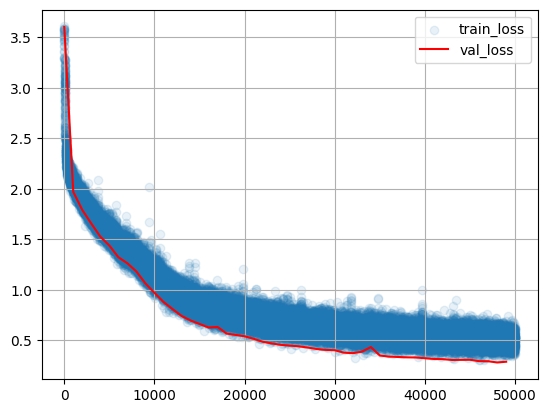

Scoring val...


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [13:48<00:00, 60.33it/s]

#49999 Val loss: 0.287


In [35]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 50000):
    batch = to_matrix(sample(train_lines, batch_size))
    augmented_batch = augment_batch(batch, p=0.5)
    
    loss_i = compute_loss(model, batch, augmented_batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(val_history):
            plt.plot(*zip(*val_history), color='red', label='val_loss')
        plt.legend(); plt.grid(); plt.show()
    
    if (i + 1) % score_val_every == 0:
        print("Scoring val...")
        val_history.append((i, score_lines(model, val_lines, batch_size)))
        print('#%i Val loss: %.3f' % val_history[-1])

In [36]:
torch.save(model.state_dict(), './autoencoder.pth')
model.load_state_dict(torch.load('./autoencoder.pth'))

device = 'cpu'

model.to(device)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (emb): Embedding(36, 64)
    (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (rnn1): LSTM(64, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (classifier): Linear(in_features=64, out_features=36, bias=True)
  )
)

In [37]:
model.get_tokens_probs(lines[0])

([1.0, 0.9582392, 0.98396933, 0.9419135],
 [('_BOS_', 1.0), ('п', 0.9582392), ('о', 0.98396933), ('_EOS_', 0.9419135)])

In [38]:
id_to_token = {value: key for key, value in token_to_id.items()}

In [39]:
print(lines[4:15])

[['_BOS_', 'в', 'а', 'д', 'а', '_EOS_'], ['_BOS_', 'р', 'и', 'т', 'ь', '_EOS_'], ['_BOS_', 'и', 'с', 'п', 'о', 'в', 'е', 'д', 'о', 'в', 'а', 'т', 'ь', '_EOS_'], ['_BOS_', 'р', 'о', 'т', '_EOS_'], ['_BOS_', 'м', 'е', 'т', 'а', 'л', 'л', '_EOS_'], ['_BOS_', 'п', 'р', 'е', 'д', 'л', 'м', 'е', 'т', '_EOS_'], ['_BOS_', 'а', 'к', 'у', 'л', 'а', '_EOS_'], ['_BOS_', 'п', 'и', 'н', 'р', 'о', '_EOS_'], ['_BOS_', 'р', 'о', 'г', 'а', 'ч', '_EOS_'], ['_BOS_', 'т', 'а', 'р', 'и', 'ф', '_EOS_'], ['_BOS_', 'г', 'л', 'и', 'н', 'я', 'н', 'ы', 'й', '_EOS_']]


In [40]:
for num in torch.argmax(model(torch.as_tensor(to_matrix(lines[4:15]))), dim=-1):
    word = ''
    for token in num:
        word += id_to_token[token.item()]
    print(word)

_BOS_вада_EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_рить_EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_ссповедовать_EOS_
_BOS_рот_EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_металл_EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_предамет_EOS__EOS__EOS__EOS__EOS_
_BOS_акула_EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_пинро_EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_рогач_EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_тариз_EOS__EOS__EOS__EOS__EOS__EOS__EOS__EOS_
_BOS_глининый_EOS__EOS__EOS__EOS__EOS_


In [41]:
def perplexity(model, line, min_logprob=np.log(10**-50.)):
    N = len(line)

    clear_probs, _ = model.get_tokens_probs(line)
    clear_probs = np.maximum(np.log(clear_probs), min_logprob)

    log_prob = np.sum(clear_probs)

    return np.exp(-log_prob / N)

In [42]:
perplexity(model, lines[0])

1.0301094554952246

In [43]:
frame = df.copy()
frame.head()

,word,is_error
0,по,0
1,всем,0
2,получить,0
3,думать,0
4,вада,0


In [44]:
frame['tokenized'] = lines

In [45]:
%%time

frame['perplexity'] = frame['tokenized'].apply(lambda x: perplexity(model, x))

CPU times: total: 9min 34s
Wall time: 1min 35s


In [46]:
frame.sort_values('perplexity', ascending=False)[:20]

,word,is_error,tokenized,perplexity
13868,юстиции,0,"[_BOS_, ю, с, т, и, ц, и, и, _EOS_]",20.613655
93496,юстиции,0,"[_BOS_, ю, с, т, и, ц, и, и, _EOS_]",20.613655
65812,захватывающая,0,"[_BOS_, з, а, х, в, а, т, ы, в, а, ю, щ, а, я,...",10.046451
8832,чрезвычайное,0,"[_BOS_, ч, р, е, з, в, ы, ч, а, й, н, о, е, _E...",9.843800
41426,принадлежностей,0,"[_BOS_, п, р, и, н, а, д, л, е, ж, н, о, с, т,...",9.798770
24602,джинсф,1,"[_BOS_, д, ж, и, н, с, ф, _EOS_]",9.297827
58919,ясновидяший,1,"[_BOS_, я, с, н, о, в, и, д, я, ш, и, й, _EOS_]",8.819493
64338,ьриллер,1,"[_BOS_, ь, р, и, л, л, е, р, _EOS_]",8.798635
13975,вглубь,0,"[_BOS_, в, г, л, у, б, ь, _EOS_]",8.600812
71493,администрайия,1,"[_BOS_, а, д, м, и, н, и, с, т, р, а, й, и, я,...",8.547315


<Axes: >

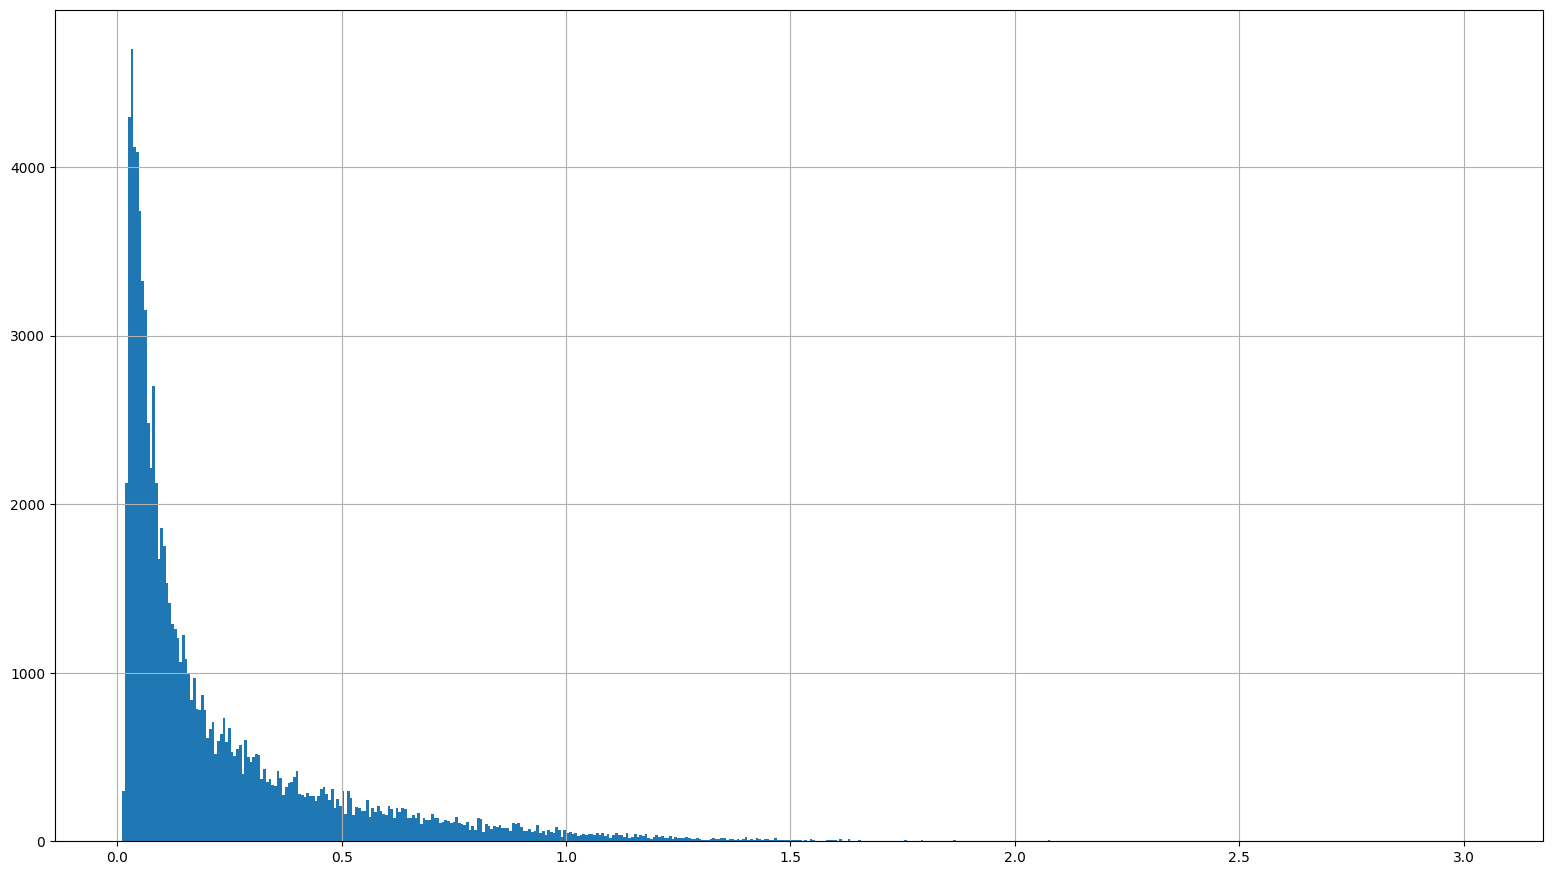

In [47]:
np.log(frame['perplexity']).hist(bins=500, figsize=(19.20, 10.80))

In [50]:
threshold = 1.5
frame['anomaly'] = 0

frame.loc[np.log(frame['perplexity']) > threshold, 'anomaly'] = 1
frame.sample(5)

,word,is_error,tokenized,perplexity,anomaly
28097,мышеловка,0,"[_BOS_, м, ы, ш, е, л, о, в, к, а, _EOS_]",1.530005,0
2356,собирать,0,"[_BOS_, с, о, б, и, р, а, т, ь, _EOS_]",1.067328,0
10809,серийный,0,"[_BOS_, с, е, р, и, й, н, ы, й, _EOS_]",1.778928,0
56150,животное,0,"[_BOS_, ж, и, в, о, т, н, о, е, _EOS_]",1.092929,0
40040,руки,0,"[_BOS_, р, у, к, и, _EOS_]",1.044618,0


In [51]:
from sklearn.metrics import classification_report
print(classification_report(frame['is_error'], frame['anomaly']))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85550
           1       0.30      0.01      0.02      8555

    accuracy                           0.91     94105
   macro avg       0.61      0.50      0.49     94105
weighted avg       0.85      0.91      0.87     94105



# False Positive Reducer

In [713]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [714]:
class AnomalyDetector(nn.Module):
    def __init__(self, n_tokens, emb_size, hid_size, eos_ix):
        super().__init__()
        self.eos = eos_ix

        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, device=device)
        self.rnn = nn.LSTM(input_size=emb_size, hidden_size=hid_size, num_layers=1, batch_first=True, bidirectional=True, device=device)

        self.classifier = nn.Linear(hid_size*2, 2)

    def __call__(self, input_ix):
        input_ix = input_ix.to(device)
        x = self.emb(input_ix)

        _, (last_h, _) = self.rnn(x)
        last_h = torch.cat((last_h[0], last_h[1]), dim=-1)

        output = self.classifier(last_h)
        return output

In [715]:
def score_val(model, val_dataloader, loss):
    val_loss_num, val_loss_len = 0., 0.
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(val_dataloader):
            outputs = model(batch_x)
            val_loss_num += loss(outputs, batch_y).item() * len(batch_x)
            val_loss_len += len(batch_x)

    return val_loss_num / val_loss_len

In [716]:
x_train, x_val, y_train, y_val = train_test_split(frame['tokenized'], frame['anomaly'], stratify=frame['anomaly'], test_size=0.25, random_state=seed)

batch_size = 64
score_val_every = 500
train_history, val_history = [], []

detector = AnomalyDetector(n_tokens=n_tokens, emb_size=16, hid_size=64, eos_ix=token_to_id[EOS])
opt = torch.optim.Adam(detector.parameters(), lr=1e-3)

detector.to(device)

AnomalyDetector(
  (emb): Embedding(36, 16)
  (rnn): LSTM(16, 64, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [717]:
from sklearn.utils.class_weight import compute_class_weight

compute_class_weight('balanced', classes=[0, 1], y=y_train)

array([1.20596678, 0.85412431])

In [718]:
class_weights = torch.tensor(compute_class_weight('balanced', classes=[0, 1], y=y_train), dtype=torch.float, device=device)
loss = nn.CrossEntropyLoss(weight=class_weights)

In [719]:
class AnomalyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        x_i = torch.as_tensor(self.x[i], dtype=torch.int64, device=device)
        y_i = torch.as_tensor(self.y[i], dtype=torch.int64, device=device)
        return x_i, y_i

In [720]:
train_dataset = AnomalyDataset(to_matrix(x_train.tolist()), y_train.values)
val_dataset = AnomalyDataset(to_matrix(x_val.tolist()), y_val.values)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

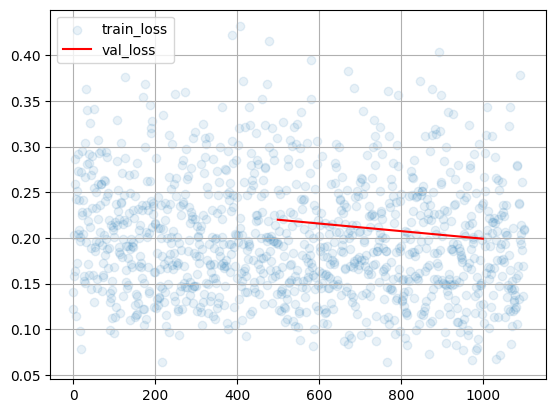

In [721]:
for epoch in range(5):
    train_history, val_history = [], []
    if epoch == 0:
        detector.eval()
        val_history.append((0, score_val(detector, val_dataloader, loss)))
    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        detector.train()
        outputs = detector(batch_x)
        loss_i = loss(outputs, batch_y.flatten())
        
        opt.zero_grad()
        loss_i.backward()
        opt.step()
            
        train_history.append((i, loss_i.item()))
        
        if (i + 1) % 50 == 0:
            clear_output(True)
            plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
            if len(val_history):
                plt.plot(*zip(*val_history), color='red', label='val_loss')
            plt.legend(); plt.grid(); plt.show()
        
        if (i + 1) % score_val_every == 0:
            print("Scoring val...")
            detector.eval()
            val_history.append((i, score_val(detector, val_dataloader, loss)))
            print('#%i Val loss: %.3f' % val_history[-1])

In [722]:
torch.save(detector.state_dict(), './detector.pth')
detector.load_state_dict(torch.load('./detector.pth'))

device = 'cpu'

detector.to(device)
detector.eval()

AnomalyDetector(
  (emb): Embedding(36, 16)
  (rnn): LSTM(16, 64, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [723]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [724]:
val_results = []
with torch.no_grad():
    for batch_x, batch_y in val_dataloader:
        outputs = F.softmax(detector(batch_x), dim=-1)
        val_results.extend(outputs[:, 1].cpu().tolist())

val_results = np.array(val_results)

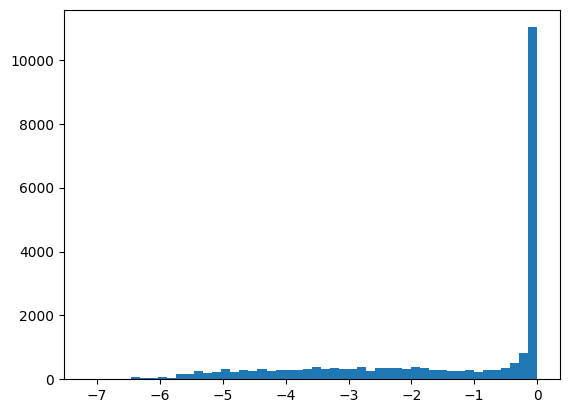

In [725]:
plt.hist(np.log(val_results), bins=50);

In [726]:
thr = 0.99

frame['verified_anomaly'] = 0
frame.loc[x_val.iloc[np.where(val_results>thr)[0]].index, 'verified_anomaly'] = 1
frame[frame['verified_anomaly'] == 1]

,word,is_error,tokenized,perplexity,anomaly,verified_anomaly
3,повелитель,0,"[_BOS_, п, о, в, е, л, и, т, е, л, ь, _EOS_]",2.416254,1,1
5,сапожник,0,"[_BOS_, с, а, п, о, ж, н, и, к, _EOS_]",1.973474,1,1
9,тяжёлое,0,"[_BOS_, т, я, ж, ё, л, о, е, _EOS_]",3.685275,1,1
17,инстркуктор,1,"[_BOS_, и, н, с, т, р, к, у, к, т, о, р, _EOS_]",3.903158,1,1
27,мультиук,1,"[_BOS_, м, у, л, ь, т, и, у, к, _EOS_]",3.419496,1,1
...,...,...,...,...,...,...
93994,преступление,0,"[_BOS_, п, р, е, с, т, у, п, л, е, н, и, е, _E...",2.307308,1,1
94069,интервью,0,"[_BOS_, и, н, т, е, р, в, ь, ю, _EOS_]",2.691027,1,1
94081,повторяемость,0,"[_BOS_, п, о, в, т, о, р, я, е, м, о, с, т, ь,...",3.909179,1,1
94087,аппрат,1,"[_BOS_, а, п, п, р, а, т, _EOS_]",1.982720,1,1


In [727]:
from sklearn.metrics import classification_report
y_val_pred = (val_results > thr).astype(int)

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      9754
           1       1.00      0.59      0.74     13773

    accuracy                           0.76     23527
   macro avg       0.82      0.80      0.76     23527
weighted avg       0.85      0.76      0.76     23527



In [728]:
train_results = []
with torch.no_grad():
    for batch_x, batch_y in train_dataloader:
        outputs = F.softmax(detector(batch_x), dim=-1)
        train_results.extend(outputs[:, 1].cpu().tolist())

train_results = np.array(train_results)

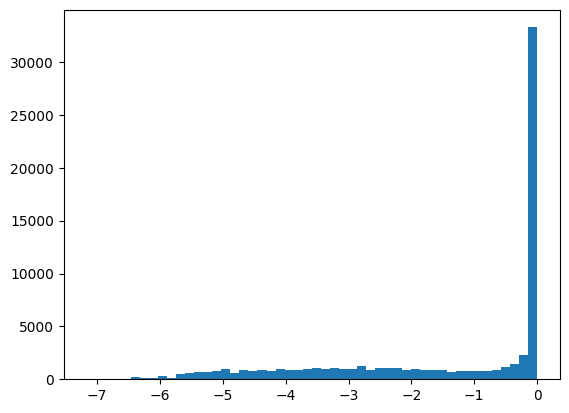

In [729]:
plt.hist(np.log(train_results), bins=50);

In [730]:
frame.loc[x_train.iloc[np.where(train_results>thr)[0]].index, 'verified_anomaly'] = 1
frame[frame['verified_anomaly'] == 1]

,word,is_error,tokenized,perplexity,anomaly,verified_anomaly
3,повелитель,0,"[_BOS_, п, о, в, е, л, и, т, е, л, ь, _EOS_]",2.416254,1,1
5,сапожник,0,"[_BOS_, с, а, п, о, ж, н, и, к, _EOS_]",1.973474,1,1
9,тяжёлое,0,"[_BOS_, т, я, ж, ё, л, о, е, _EOS_]",3.685275,1,1
12,подъезда,0,"[_BOS_, п, о, д, ъ, е, з, д, а, _EOS_]",2.025314,1,1
13,мансарда,0,"[_BOS_, м, а, н, с, а, р, д, а, _EOS_]",2.066318,1,1
...,...,...,...,...,...,...
94085,поцелуй,0,"[_BOS_, п, о, ц, е, л, у, й, _EOS_]",2.095206,1,1
94087,аппрат,1,"[_BOS_, а, п, п, р, а, т, _EOS_]",1.982720,1,1
94098,чистюля,0,"[_BOS_, ч, и, с, т, ю, л, я, _EOS_]",3.292989,1,1
94101,телевидение,0,"[_BOS_, т, е, л, е, в, и, д, е, н, и, е, _EOS_]",1.917382,1,1


In [731]:
y_train_pred = (train_results > thr).astype(int)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     29262
           1       1.00      0.60      0.75     41316

    accuracy                           0.76     70578
   macro avg       0.82      0.80      0.76     70578
weighted avg       0.85      0.76      0.76     70578



In [732]:
print(classification_report(frame['is_error'], frame['verified_anomaly']))

              precision    recall  f1-score   support

           0       0.91      0.65      0.76     85550
           1       0.10      0.37      0.15      8555

    accuracy                           0.63     94105
   macro avg       0.50      0.51      0.46     94105
weighted avg       0.84      0.63      0.71     94105

